In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
img_size = 256, 256

transform = transforms.Compose(
    [transforms.Resize(img_size),transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4


trainset = torchvision.datasets.ImageFolder(root='./xray_data', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.ImageFolder(root='./xray_data', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('normal', 'cardiomegaly')

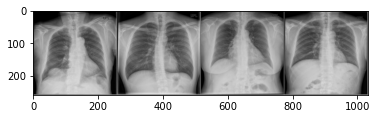

normal normal normal normal


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [7]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.fc1 = nn.Linear(74420, 500)
        self.fc2 = nn.Linear(500, 50)
        self.fc3 = nn.Linear(50, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # 배치를 제외한 모든 차원을 평탄화(flatten)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=74420, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=2, bias=True)
)


In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [10]:
for epoch in range(2):   # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 0.466
[1,   400] loss: 0.447
[1,   600] loss: 0.440
[2,   200] loss: 0.439
[2,   400] loss: 0.411
[2,   600] loss: 0.415
Finished Training


In [11]:
PATH = './test_net1.pth'
torch.save(net.state_dict(), PATH)

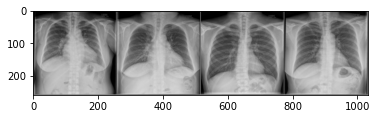

GroundTruth:  normal normal normal normal


In [12]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# 이미지를 출력합니다.
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [13]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [14]:
outputs = net(images)

In [15]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  normal normal normal normal


In [16]:
correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = net(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 83 %


In [17]:
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class normal is: 93.2 %
Accuracy for class cardiomegaly is: 63.8 %


In [76]:
import torch
from random import randint
import random
class SMOTE(object):
    def __init__(self,distance='euclidian',dims=512,k=5):
        super(SMOTE,self).__init__()
        self.newindex = 0 
        self.k = k
        self.dims = dims
        self.distance_measure = distance
        
    def populate(self, N,i,nnarray,min_samples,k):
        while N:
            nn = randint(0, k-2)
            
            diff = min_samples[nnarray[nn]] - min_samples[i]
            gap = random.uniform(0,1)

            self.synthetic_arr[self.newindex,:] = min_samples[i] + gap * diff
            
            self.newindex += 1
            
            N -= 1
    def k_neighbors(self, euclid_distance, k):
        nearest_idx = torch.zeros((euclid_distance.shape[0],euclid_distance.shape[0]), dtype = torch.int64)
        
        idxs = torch.argsort(euclid_distance, dim=1)
        nearest_idx[:,:] = idxs
        
        return nearest_idx[:,1:k]
    
    def find_k(self,X,k):
        euclid_distance = torch.zeros((X.shape[0],X.shape[0]), dtype = torch.float32)
        
        for i in range(len(X)):
            dif = (X - X[i])**2
            dist = torch.sqrt(dif.sum(axis=1))
            euclid_distance[i] = dist
            
        return self.k_neighbors(euclid_distance,k)
    
    def generate(self, min_samples, N,k):
        """
            Returns (N/100) * n_minority_samples synthetic minority samples.
    		Parameters
    		----------
    		min_samples : Numpy_array-like, shape = [n_minority_samples, n_features]
    		    Holds the minority samples
    		N : percetange of new synthetic samples: 
    		    n_synthetic_samples = N/100 * n_minority_samples. Can be < 100.
    		k : int. Number of nearest neighbours. 
    		Returns
    		-------
    		S : Synthetic samples. array, 
    		    shape = [(N/100) * n_minority_samples, n_features]. 
    	"""
        T = min_samples.shape[0]
        self.synthetic_arr = torch.zeros(int(N/100)*T,self.dims)
        N = int(N/100)
        if self.distance_measure == 'euclidian':
            indices = self.find_k(min_samples,k)
        for i in range(indices.shape[0]):
            self.populate(N, i, indices[i], min_samples, k)
        self.newindex = 0 
        return self.synthetic_arr
            
    def fit_generate(self,X,y):
        #get occurence of each class
        occ = torch.eye(int(y.max()+1),int(y.max()+1))[y].sum(axis=0)
        #get the dominant class
        dominant_class = torch.argmax(occ)
        #get occurence of the dominant class
        n_occ = int(occ[dominant_class].item())
        for i in range(len(occ)):
            if i != dominant_class:
                #calculate the amount of synthetic data to generate
                N = (n_occ - occ[i]) * 100 / occ[i]
                candidates = X[y == i]
                xs = self.generate(candidates, N,self.k)
                X = torch.cat((X,xs))
                ys = torch.ones(xs.shape[0]) * i
                y = torch.cat((y,ys))
        return X,y

In [72]:
smote = SMOTE()

In [73]:
smote.fit_generate(classes, predicted)

AttributeError: 'str' object has no attribute 'shape'

In [74]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)

print(type(X))
print(type(_))
print(type(predicted))

<class 'numpy.ndarray'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [79]:
X, y = smote.fit_generate(predicted[0], predicted)

IndexError: too many indices for tensor of dimension 0